In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load the data
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [1]:
import sqlite3
import zipfile

# Unzip the database file
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Connect to the database
conn = sqlite3.connect('zippedData/im.db')
cursor = conn.cursor()

# Get the list of tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Preview all columns from each table
for table in tables:
    table_name = table[0]
    print(f"Table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    for column in columns:
        print(column)
    print("\n")

Table: movie_basics
(0, 'movie_id', 'TEXT', 0, None, 0)
(1, 'primary_title', 'TEXT', 0, None, 0)
(2, 'original_title', 'TEXT', 0, None, 0)
(3, 'start_year', 'INTEGER', 0, None, 0)
(4, 'runtime_minutes', 'REAL', 0, None, 0)
(5, 'genres', 'TEXT', 0, None, 0)


Table: directors
(0, 'movie_id', 'TEXT', 0, None, 0)
(1, 'person_id', 'TEXT', 0, None, 0)


Table: known_for
(0, 'person_id', 'TEXT', 0, None, 0)
(1, 'movie_id', 'TEXT', 0, None, 0)


Table: movie_akas
(0, 'movie_id', 'TEXT', 0, None, 0)
(1, 'ordering', 'INTEGER', 0, None, 0)
(2, 'title', 'TEXT', 0, None, 0)
(3, 'region', 'TEXT', 0, None, 0)
(4, 'language', 'TEXT', 0, None, 0)
(5, 'types', 'TEXT', 0, None, 0)
(6, 'attributes', 'TEXT', 0, None, 0)
(7, 'is_original_title', 'REAL', 0, None, 0)


Table: movie_ratings
(0, 'movie_id', 'TEXT', 0, None, 0)
(1, 'averagerating', 'REAL', 0, None, 0)
(2, 'numvotes', 'INTEGER', 0, None, 0)


Table: persons
(0, 'person_id', 'TEXT', 0, None, 0)
(1, 'primary_name', 'TEXT', 0, None, 0)
(2, 'birth_y

In [150]:
# Filter out records with start_year before 2010
cursor.execute(f"DELETE FROM movie_basics WHERE start_year < 2010")
conn.commit()

In [151]:
# Query the movie_basics table
movie_basics_df = pd.read_sql_query("SELECT * FROM movie_basics", conn)

# Drop unnecessary columns
movie_basics_df = movie_basics_df.drop(columns=['original_title'])

# Filter
movie_basics_df = movie_basics_df[movie_basics_df['genres'].notnull()]
movie_basics_df = movie_basics_df[movie_basics_df['runtime_minutes'].notnull() & movie_basics_df['runtime_minutes'] > 0]

# Replace the commas in genres with | to make the data more consistent with other dataframes
movie_basics_df['genres'] = movie_basics_df['genres'].str.replace(',', '|')
movie_basics_df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,Action|Crime|Drama
1,tt0066787,One Day Before the Rainy Season,2019,114.0,Biography|Drama
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
4,tt0100275,The Wandering Soap Opera,2017,80.0,Comedy|Drama|Fantasy
5,tt0111414,A Thin Life,2018,75.0,Comedy


In [152]:
# Filter dataframes to only contain records after 2010
movie_gross_df = movie_gross_df[movie_gross_df['year'] >= 2010]
rt_movie_info = rt_movie_info[pd.to_datetime(rt_movie_info['theater_date'], format='mixed').dt.year >= 2010]
tmdb_movies = tmdb_movies[pd.to_datetime(tmdb_movies['release_date'], format='mixed').dt.year >= 2010]
tn_movie_budgets = tn_movie_budgets[pd.to_datetime(tn_movie_budgets['release_date'], format='mixed').dt.year >= 2010]

# Convert values that should be numeric to numeric
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype(str).str.replace(',', '').astype(float)

rt_movie_info['runtime'] = rt_movie_info['runtime'].astype(str).str.replace(' minutes', '').fillna(0).replace('nan', '0').astype(int)
rt_movie_info['box_office'] = rt_movie_info['box_office'].astype(str).str.replace(',', '').replace('nan', '0').astype(int)

tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].astype(str).str.replace('$', '').str.replace(',', '').replace('nan', '0').astype(int)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].astype(str).str.replace('$', '').str.replace(',', '').replace('nan', '0').astype(int)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].astype(str).str.replace('$', '').str.replace(',', '').replace('nan', '0').astype(int)

In [153]:
# Ensure the primary_title column in movie_basics_df is unique
movie_basics_df = movie_basics_df.drop_duplicates(subset=['primary_title'])

# Assign each movie with its corresponding movie_id
tn_movie_budgets['movie_id'] = tn_movie_budgets['movie'].map(movie_basics_df.set_index('primary_title')['movie_id'])

# Merge the two dataframes on the movie_id column
master_movie_df = pd.merge(tn_movie_budgets, movie_basics_df, on='movie_id', how='inner')
master_movie_df = master_movie_df.drop(columns=['id', 'primary_title'])
master_movie_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,2011,136.0,Action|Adventure|Fantasy
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,2019,113.0,Action|Adventure|Sci-Fi
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,2015,141.0,Action|Adventure|Sci-Fi
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,2018,149.0,Action|Adventure|Sci-Fi
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,tt0974015,2017,120.0,Action|Adventure|Fantasy


In [154]:
# In the SQL database, join the directors table with the persons table on the person_id column
directors_df = pd.read_sql_query("SELECT * FROM directors JOIN persons ON directors.person_id = persons.person_id", conn)
directors_df.head()

,movie_id,person_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0285252,nm0899854,nm0899854,Tony Vitale,1964.0,NaN,"producer,director,writer"
1,tt0462036,nm1940585,nm1940585,Bill Haley,NaN,NaN,"director,writer,producer"
2,tt0835418,nm0151540,nm0151540,Jay Chandrasekhar,1968.0,NaN,"director,actor,writer"
3,tt0835418,nm0151540,nm0151540,Jay Chandrasekhar,1968.0,NaN,"director,actor,writer"
4,tt0878654,nm0089502,nm0089502,Albert Pyun,1954.0,NaN,"director,writer,producer"


In [155]:
# Clean
directors_df = directors_df.drop(columns=['birth_year', 'death_year', 'primary_profession'])
directors_df = directors_df[directors_df['primary_name'].notnull()]
directors_df = directors_df.drop_duplicates(subset=['movie_id'])
directors_df = directors_df.loc[:,~directors_df.T.duplicated(keep='first')]
directors_df.head()

,movie_id,person_id,primary_name
0,tt0285252,nm0899854,Tony Vitale
1,tt0462036,nm1940585,Bill Haley
2,tt0835418,nm0151540,Jay Chandrasekhar
4,tt0878654,nm0089502,Albert Pyun
7,tt0879859,nm2416460,Eric Manchester


In [9]:
# Merge master_movie_df with directors_df on the 'movie_id' column
master_movie_df = pd.merge(master_movie_df, directors_df, on='movie_id', how='inner')

master_movie_df = master_movie_df.rename(columns={'primary_name': 'director'})
master_movie_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,2011,136.0,Action|Adventure|Fantasy,nm0551128,Rob Marshall
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,2019,113.0,Action|Adventure|Sci-Fi,nm1334526,Simon Kinberg
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,2015,141.0,Action|Adventure|Sci-Fi,nm0923736,Joss Whedon
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,2018,149.0,Action|Adventure|Sci-Fi,nm0751577,Anthony Russo
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,tt0974015,2017,120.0,Action|Adventure|Fantasy,nm0811583,Zack Snyder


In [10]:
master_movie_df = master_movie_df[master_movie_df.domestic_gross > 0]
master_movie_df = master_movie_df[master_movie_df.worldwide_gross > 0.0]
merged_df = master_movie_df[master_movie_df.production_budget > 0]
master_movie_df = master_movie_df.dropna()
master_movie_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,2011,136.0,Action|Adventure|Fantasy,nm0551128,Rob Marshall
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,2019,113.0,Action|Adventure|Sci-Fi,nm1334526,Simon Kinberg
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,2015,141.0,Action|Adventure|Sci-Fi,nm0923736,Joss Whedon
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,2018,149.0,Action|Adventure|Sci-Fi,nm0751577,Anthony Russo
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,tt0974015,2017,120.0,Action|Adventure|Fantasy,nm0811583,Zack Snyder


There are 230 different genres/genre combinations that categorize each movie.

In [11]:
master_movie_df['genres'].value_counts()

genres
Adventure|Animation|Comedy     65
Drama                          65
Comedy|Drama|Romance           58
Comedy|Drama                   57
Action|Adventure|Sci-Fi        53
                               ..
Biography|Documentary           1
Comedy|Documentary|Drama        1
Comedy|Horror|Sci-Fi            1
Adventure|Comedy|Romance        1
Biography|Documentary|Music     1
Name: count, Length: 230, dtype: int64

Here is a visual depicting the number of films belonging to each genre.

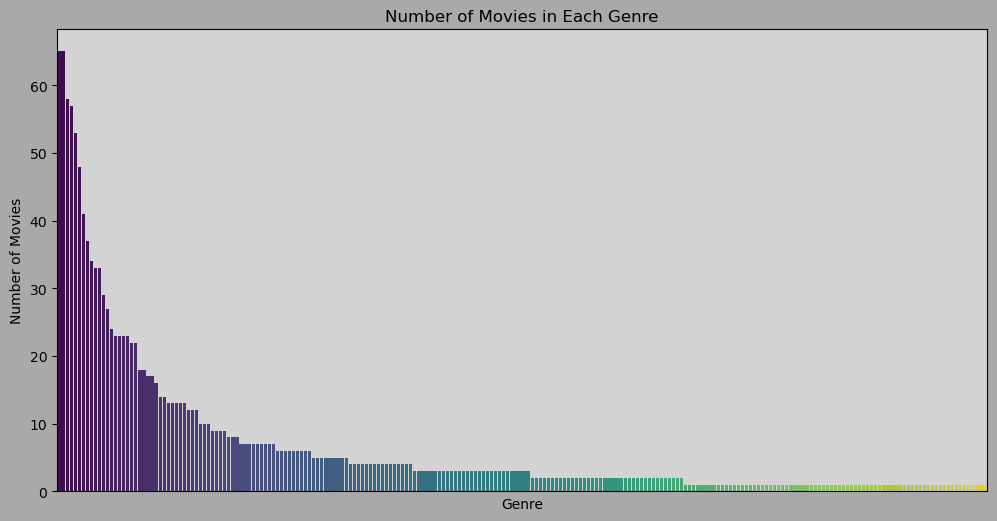

In [12]:
# Count the number of movies in each genre
genre_counts = master_movie_df['genres'].value_counts()

plt.figure(figsize=(12, 6), facecolor='#a9a9a9')  # Set a darker grey background color
ax = plt.gca()  # Get the current axes
ax.set_facecolor('#d3d3d3')
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette='viridis', legend=False)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Genre')
plt.xticks([])  # Remove x-tick labels
plt.show()

Let's narrow this down.

In [13]:
# Extract the top 3 most frequent movie genres from genre_counts
top_genres = genre_counts.head(3)
top_genres

genres
Adventure|Animation|Comedy    65
Drama                         65
Comedy|Drama|Romance          58
Name: count, dtype: int64

There are still a significant amount of movies within the three most frequent genres. To determine which movies have seen the most success within a particular genre, let's look at the most prevalent directors and the movies they have headed.

In [64]:
aac_movies = master_movie_df[master_movie_df['genres'] == 'Adventure|Animation|Comedy']
aac_movies['director'].value_counts().head(3)

director
Mike Mitchell      4
Carlos Saldanha    3
Pierre Coffin      2
Name: count, dtype: int64

Here are the four Adventure|Animation|Comedy movies directed by Mike Mitchell.

In [15]:
aac_movies[aac_movies['director'] == 'Mike Mitchell']

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
86,"May 21, 2010",Shrek Forever After,165000000,238736787,756244673,tt0892791,2010,93.0,Adventure|Animation|Comedy,nm0593610,Mike Mitchell
164,"Nov 4, 2016",Trolls,125000000,153707064,344150134,tt1679335,2016,92.0,Adventure|Animation|Comedy,nm0593610,Mike Mitchell
267,"Dec 16, 2011",Alvin and the Chipmunks: Chipwrecked,80000000,133107389,349088523,tt1615918,2011,87.0,Adventure|Animation|Comedy,nm0593610,Mike Mitchell
294,"Feb 6, 2015",The SpongeBob Movie: Sponge Out of Water,74000000,162994032,311013181,tt2279373,2015,92.0,Adventure|Animation|Comedy,nm0593610,Mike Mitchell


Here is a visualization showcasing the range of production budgets, so we can better understand the significance of Mike Mitchell's figures.

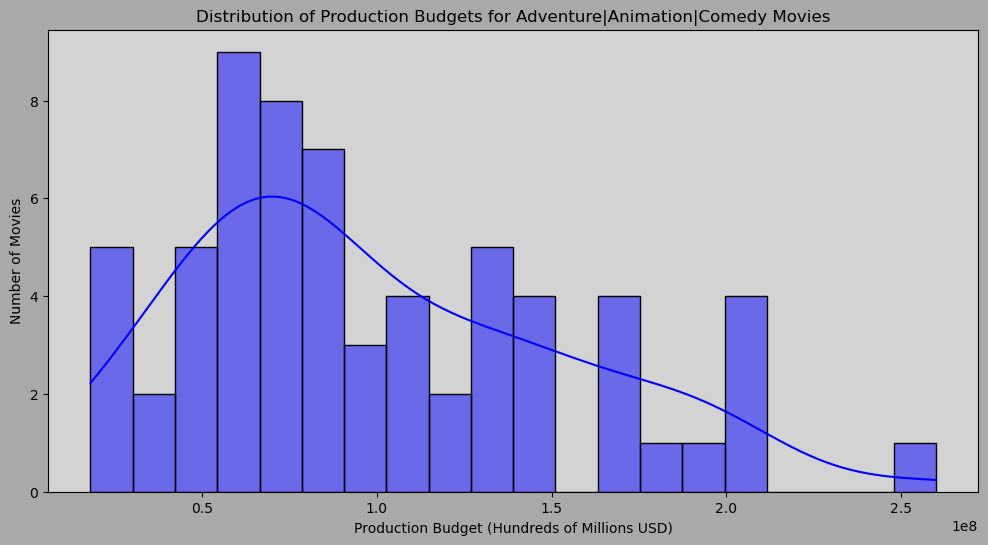

In [107]:
plt.figure(figsize=(12, 6), facecolor='#a9a9a9')  # Set a darker grey background color
ax = plt.gca()  # Get the current axes
ax.set_facecolor('#d3d3d3')
sns.histplot(aac_movies['production_budget'], bins=20, kde=True, color='blue')
plt.xlabel('Production Budget (Hundreds of Millions USD)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Production Budgets for Adventure|Animation|Comedy Movies')
plt.show()


In [75]:
aac_movies['production_budget'].describe()

count    6.500000e+01
mean     1.000692e+08
std      5.432180e+07
min      1.800000e+07
25%      6.000000e+07
50%      8.000000e+07
75%      1.350000e+08
max      2.600000e+08
Name: production_budget, dtype: float64

According to the chart and descriptive statistics of this parameter, 50% of all `Adventure|Animation|Comedy` movies have a budget less than **$80,000,000** for production. 

This means that Mike Mitchell received an incredibly high budget for his work on _Shrek Forever After_ and _Trolls_. He likely has a great reputation as a director, earning him a higher production budget (**$165,000,000** and **$125,000,000**, respectively).

Let's compare the revenue figures of those two movies to other `Adventure|Animation|Comedy` films.

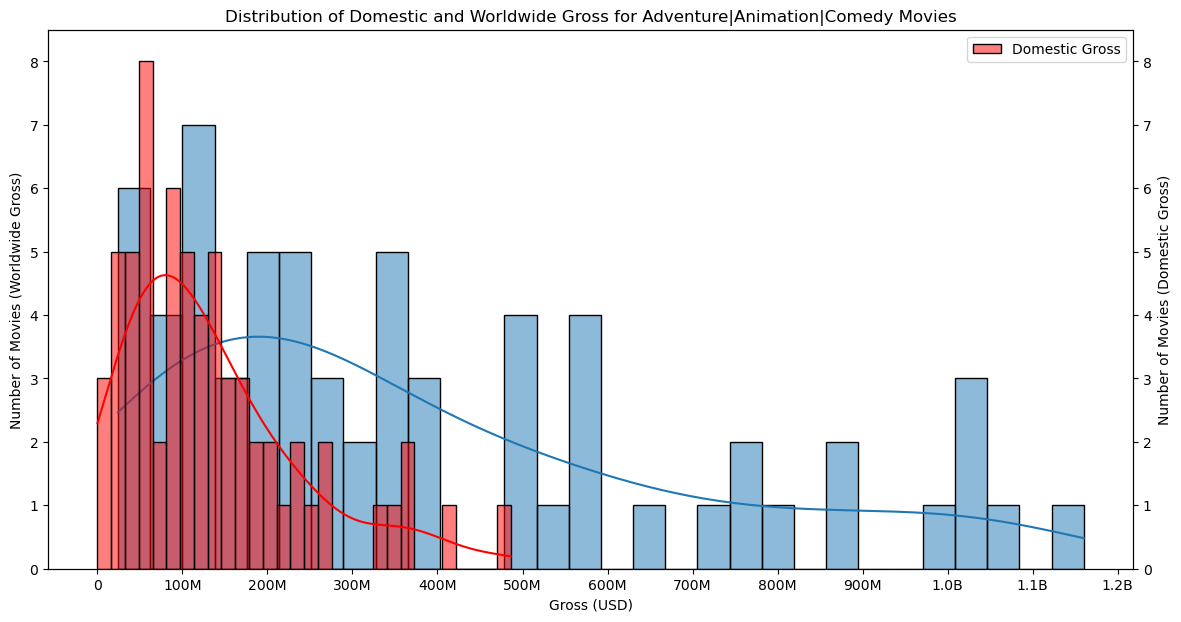

In [145]:
plt.figure(figsize=(14, 7))

# Plot worldwide gross
sns.histplot(aac_movies['worldwide_gross'], bins=30, kde=True, label='Worldwide Gross')
plt.xlabel('Gross (USD)')
plt.ylabel('Number of Movies (Worldwide Gross)')
plt.title('Distribution of Domestic and Worldwide Gross for Adventure|Animation|Comedy Movies')
plt.yticks(np.arange(0, 8.5, step=1))
plt.ylim(0, 8.5)

# Create a secondary y-axis for domestic gross
ax2 = plt.gca().twinx()
sns.histplot(aac_movies['domestic_gross'], bins=30, kde=True, label='Domestic Gross', color='red', ax=ax2)
ax2.set_ylabel('Number of Movies (Domestic Gross)')
ax2.set_yticks(np.arange(0, 8.5, step=1))
ax2.set_ylim(0, 8.5)

# Add legends
plt.legend(loc='upper right')

# Adjust the number of ticks and labels to match
ticks = np.arange(0, aac_movies['worldwide_gross'].max() + 1e8, step=1e8)
labels = [f'{int(tick/1e8)}00M' if tick < 1e9 else f'{tick/1e9:.1f}B' for tick in ticks]
labels[0] = '0'
plt.xticks(ticks, labels)

plt.show()

In [146]:
aac_movies['domestic_gross'].describe()

count    6.500000e+01
mean     1.340565e+08
std      1.059739e+08
min      4.091000e+03
25%      5.600305e+07
50%      1.080853e+08
75%      1.750030e+08
max      4.862956e+08
Name: domestic_gross, dtype: float64

In [2]:
aac_movies['worldwide_gross'].describe()

NameError: name 'aac_movies' is not defined

_Shrek Forever After_ and _Trolls_ earned **$238,736,787** and **$153,707,064** in gross domestic revenue, respectively.

Compared to 50% of movies that earned less than ~**$108,085,000** in gross domestic revenue, these are tremendously significant figures.

***

Adding on to that, both movies earned **$756,244,673** and **$344,150,134** in gross worldwide revenue, respectively. 

Compared to 50% of movies that earned less than ~**$286,896,000** in gross worldwide revenue, these figures are doubly significant.

It can be said with certainty that Mike Mitchell directs highly successful `Adventure|Animation|Comedy` films when given a large production budget.

### Repeat the process for `Drama` films.

In [49]:
dram_movies = master_movie_df[master_movie_df['genres'] == 'Drama']

dram_movies['director'].value_counts().head(3)

director
Alex Kendrick       2
Kenneth Lonergan    2
Muzaffer Özdemir    1
Name: count, dtype: int64

In [50]:
dram_movies[dram_movies['director'] == 'Alex Kendrick']

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
1417,"Aug 28, 2015",War Room,3000000,67790117,73975239,tt3832914,2015,120.0,Drama,nm1731937,Alex Kendrick
1480,"Sep 30, 2011",Courageous,2000000,34522221,35185884,tt1630036,2011,129.0,Drama,nm1731937,Alex Kendrick


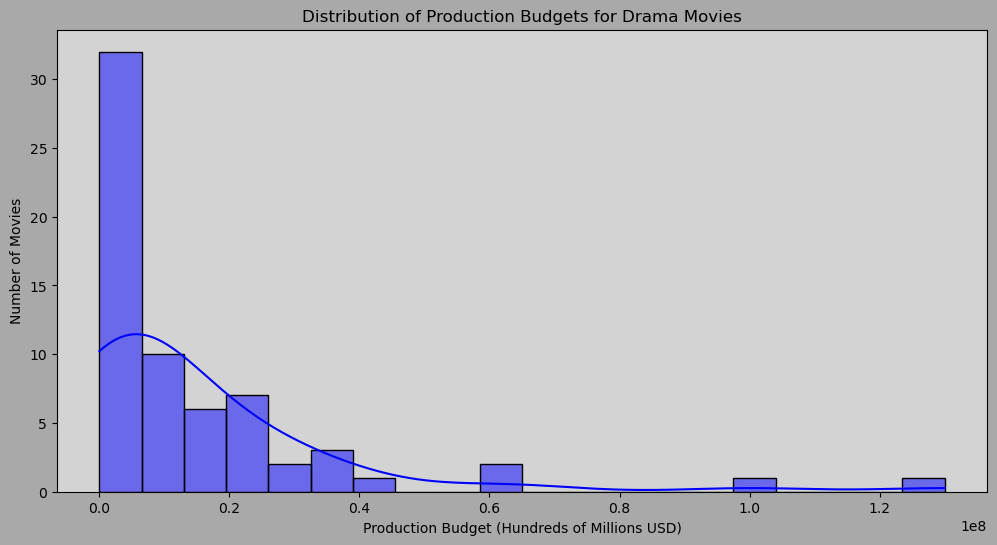

In [108]:
plt.figure(figsize=(12, 6), facecolor='#a9a9a9')  # Set a darker grey background color
ax = plt.gca()  # Get the current axes
ax.set_facecolor('#d3d3d3')
sns.histplot(dram_movies['production_budget'], bins=20, kde=True, color='blue')
plt.xlabel('Production Budget (Hundreds of Millions USD)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Production Budgets for Drama Movies')
plt.show()

In [104]:
dram_movies['production_budget'].describe()

count    6.500000e+01
mean     1.522857e+07
std      2.291511e+07
min      2.700000e+04
25%      2.000000e+06
50%      8.000000e+06
75%      2.000000e+07
max      1.300000e+08
Name: production_budget, dtype: float64

Alex Kendrick's production budgets of **$3,000,000** for *War Room* and **$2,000,000** for *Courageous* are significantly small, compared to other `Drama` films, which average ~**$15,000,000**.

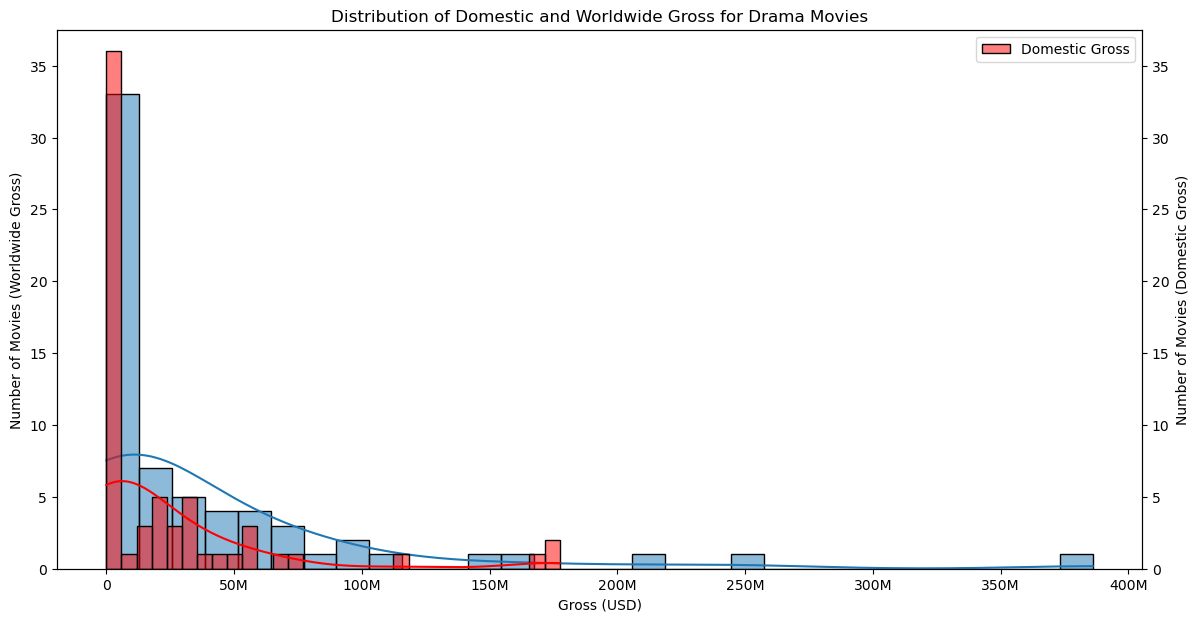

In [144]:
plt.figure(figsize=(14, 7))

# Plot worldwide gross
sns.histplot(dram_movies['worldwide_gross'], bins=30, kde=True, label='Worldwide Gross')
plt.xlabel('Gross (USD)')
plt.ylabel('Number of Movies (Worldwide Gross)')
plt.title('Distribution of Domestic and Worldwide Gross for Drama Movies')
plt.yticks(np.arange(0, 37.5, step=5))
plt.ylim(0, 37.5)

# Create a secondary y-axis for domestic gross
ax2 = plt.gca().twinx()
sns.histplot(dram_movies['domestic_gross'], bins=30, kde=True, label='Domestic Gross', color='red', ax=ax2)
ax2.set_ylabel('Number of Movies (Domestic Gross)')
ax2.set_yticks(np.arange(0, 35.5, step=5))
ax2.set_ylim(0, 37.5)

# Add legends
plt.legend(loc='upper right')

# Adjust the number of ticks and labels to match
ticks = np.arange(0, dram_movies['worldwide_gross'].max() + 5e7, step=5e7)
labels = [f'{int(tick/1e7)}0M' if tick < 1e9 else f'{tick/1e9:.1f}B' for tick in ticks]
labels[0] = '0'
plt.xticks(ticks, labels)

plt.show()

In [113]:
dram_movies['domestic_gross'].describe()

count    6.500000e+01
mean     2.356561e+07
std      4.030571e+07
min      2.636000e+03
25%      4.541210e+05
50%      5.310554e+06
75%      3.144501e+07
max      1.773975e+08
Name: domestic_gross, dtype: float64

In [114]:
dram_movies['worldwide_gross'].describe()

count    6.500000e+01
mean     3.932068e+07
std      6.749499e+07
min      2.636000e+03
25%      7.974390e+05
50%      1.239456e+07
75%      5.064742e+07
max      3.859979e+08
Name: worldwide_gross, dtype: float64

50% of Domestic Gross for `Drama` films: ~**$5,310,000**

* Alex Kendrick's Gross Domestic Revenue on *War Room*: **$67,790,117**

* For *Courageous*: **$34,522,221**

50% of Worldwide Gross for `Drama` films: ~**$12,395,000**

* Alex Kendrick's Gross Worldwide Revenue on *War Room*: **$73,975,239**

* For *Courageous*: **$35,185,884**

Despite receiving a tremendously low production budget, Alex Kendrick accomplished an admirable feat. He brought in almost triple the amount of worldwide revenue from his film *Courageous* that 50% of other `Drama` films brought in. If you thought that was impressive, with *War Room*, he almost sextupled that figure.

He achieved these revenue figures on a budget that was 20% of the genre's *average* budget.

### Repeat the process for `Comedy|Drama|Romance` films

In [128]:
cdr_movies = master_movie_df[master_movie_df['genres'] == 'Comedy|Drama|Romance']

cdr_movies['director'].value_counts().head(3)

director
Greg Berlanti    2
Tom Tykwer       2
Rob Reiner       2
Name: count, dtype: int64

In [130]:
cdr_movies[cdr_movies['director'] == 'Greg Berlanti']

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
534,"Oct 8, 2010",Life as We Know It,38000000,53374681,105887837,tt1055292,2010,114.0,Comedy|Drama|Romance,nm0075528,Greg Berlanti
1099,"Mar 16, 2018","Love, Simon",10000000,40826341,65520633,tt5164432,2018,110.0,Comedy|Drama|Romance,nm0075528,Greg Berlanti


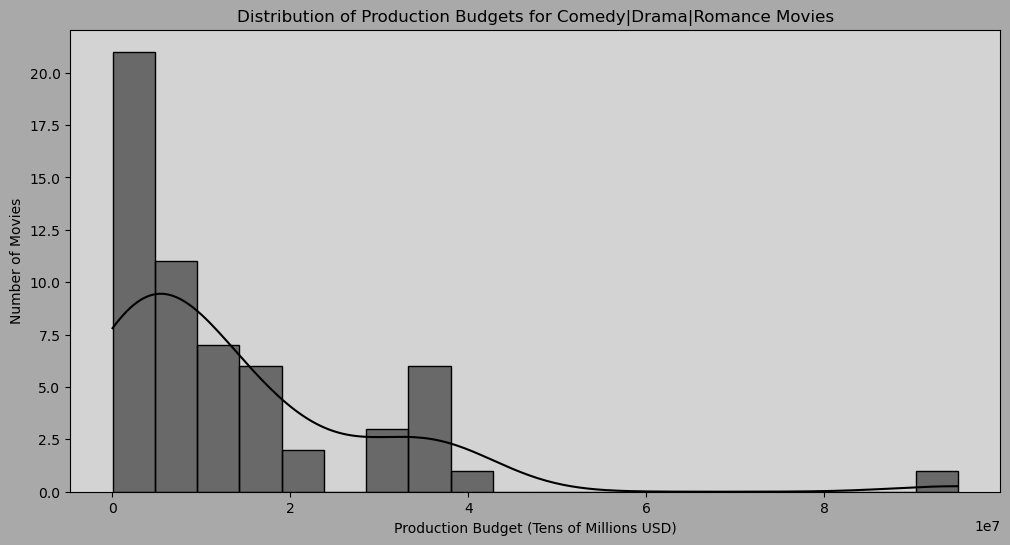

In [135]:
plt.figure(figsize=(12, 6), facecolor='#a9a9a9')  # Set a darker grey background color
ax = plt.gca()  # Get the current axes
ax.set_facecolor('#d3d3d3')
sns.histplot(cdr_movies['production_budget'], bins=20, kde=True, color='k')
plt.xlabel('Production Budget (Tens of Millions USD)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Production Budgets for Comedy|Drama|Romance Movies')
plt.show();

In [136]:
cdr_movies['production_budget'].describe()

count    5.800000e+01
mean     1.351767e+07
std      1.620198e+07
min      5.000000e+04
25%      3.000000e+06
50%      8.000000e+06
75%      1.875000e+07
max      9.500000e+07
Name: production_budget, dtype: float64

Greg Berlanti's production budget for his film *Life as We Know It* was **$38,000,000**, which is more than double the budget for 75% of other films in the genre.

His budget for *Love, Simon* was **$10,000,000**, a figure on par with 50% of movies in the genre.

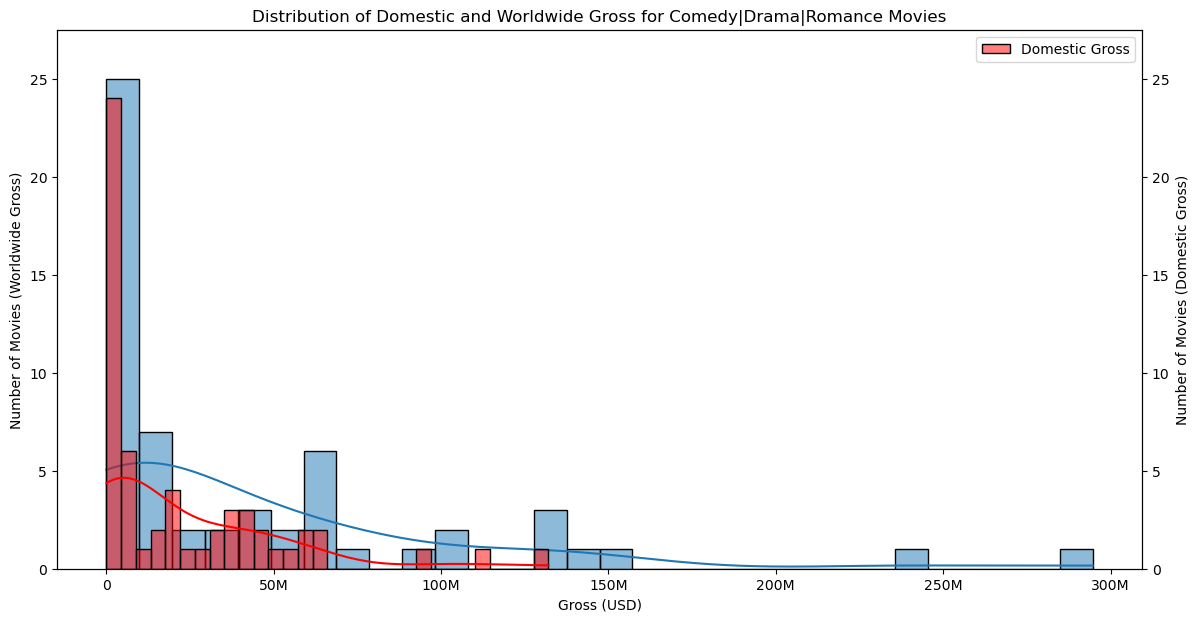

In [142]:
plt.figure(figsize=(14, 7))

# Plot worldwide gross
sns.histplot(cdr_movies['worldwide_gross'], bins=30, kde=True, label='Worldwide Gross')
plt.xlabel('Gross (USD)')
plt.ylabel('Number of Movies (Worldwide Gross)')
plt.title('Distribution of Domestic and Worldwide Gross for Comedy|Drama|Romance Movies')
plt.yticks(np.arange(0, 27.5, step=5))
plt.ylim(0, 27.5)

# Create a secondary y-axis for domestic gross
ax2 = plt.gca().twinx()
sns.histplot(cdr_movies['domestic_gross'], bins=30, kde=True, label='Domestic Gross', color='red', ax=ax2)
ax2.set_ylabel('Number of Movies (Domestic Gross)')
ax2.set_yticks(np.arange(0, 27.5, step=5))
ax2.set_ylim(0, 27.5)

# Add legends
plt.legend(loc='upper right')

# Adjust the number of ticks and labels to match
ticks = np.arange(0, cdr_movies['worldwide_gross'].max() + 5e7, step=5e7)
labels = [f'{int(tick/1e7)}0M' if tick < 1e9 else f'{tick/1e9:.1f}B' for tick in ticks]
labels[0] = '0'
plt.xticks(ticks, labels)

plt.show();

In [147]:
cdr_movies['domestic_gross'].describe()

count    5.800000e+01
mean     2.309067e+07
std      2.917344e+07
min      2.602000e+03
25%      1.851765e+06
50%      6.890520e+06
75%      3.922329e+07
max      1.320930e+08
Name: domestic_gross, dtype: float64

In [148]:
cdr_movies['worldwide_gross'].describe()

count    5.800000e+01
mean     4.305613e+07
std      5.995763e+07
min      2.602000e+03
25%      4.323074e+06
50%      1.611721e+07
75%      6.129462e+07
max      2.946808e+08
Name: worldwide_gross, dtype: float64

***

50% of other `Comedy|Drama|Romance` films:

* Domestic: ~**$6,890,000**

* Worldwide: ~**$16,000,000**

*Life as We Know It*:

* Domestic: **$53,374,681**

* Worldwide: **$105,887,837**

*Love, Simon*:

* Domestic: **$40,826,341**

* Worldwide: **$65,520,633**

***

Here, we can see that Greg Berlanti significantly outperformed other films in the genre. However, something important to note is that his budget for *Life as We Know It* was incredibly high, compared to other `Comedy|Drama|Romance` films. On the other hand, his budget for *Love, Simon* was nearly 25% of his other film's.

If we compare this metrics deeper:

With a budget of **$10,000,000** for *Love, Simon* and a gross domestic of **$40,826,341**, he realized about a 308.26% profit, assuming he spent all of his budget.

With a budget of **$38,000,000** for *Life as We Know It* and a gross domestic of **$53,374,681**, he realized about a 40.46% profit, assuming he spent all of his budget.

These are two very different cases for Greg Berlanti. Perhaps, a little too inconsistent to recommend him as a good director for a `Comedy|Drama|Romance` film. 

Let's look at the other directors.

In [156]:
cdr_movies['director'].value_counts().head(3)

director
Greg Berlanti    2
Tom Tykwer       2
Rob Reiner       2
Name: count, dtype: int64

In [157]:
cdr_movies[cdr_movies['director'] == 'Tom Tykwer']

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
598,"Apr 22, 2016",A Hologram for the King,35000000,4212494,11846010,tt2980210,2016,98.0,Comedy|Drama|Romance,nm0878756,Tom Tykwer
1230,"Sep 16, 2011",3,7200000,59774,295492,tt1517177,2010,119.0,Comedy|Drama|Romance,nm0878756,Tom Tykwer


Looks like Tom Tykwer has had two significant projects worth investigating.

The first on the list, *A Hologram for the King*, boasts a significant production budget of **$35,000,000**, which is on par with the figures of Greg Berlanti's *Life as We Know It*.

If we calculate the total return on investment, like we did for Berlanti's projects:

***

*A Hologram for the King*:

* Domestic: **$4,212,494**

* Worldwide: **$11,846,010**

*3*:

* Domestic: **$59,774**

* Worldwide: **$295,492**

***

Both of these projects were unable to turn a profit. It is definitely safe to assume that we will not see any films directed by Tom Tykwer any time soon.

In [158]:
cdr_movies[cdr_movies['director'] == 'Rob Reiner']

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,runtime_minutes,genres,person_id,director
912,"Jul 25, 2014",And So It Goes,18000000,15160801,17920013,tt2465146,2014,94.0,Comedy|Drama|Romance,nm0001661,Rob Reiner
1006,"Aug 6, 2010",Flipped,14000000,1755212,4289993,tt0817177,2010,90.0,Comedy|Drama|Romance,nm0001661,Rob Reiner


***

*And So It Goes*:

* Budget: **$18,000,000**

* Domestic: **$15,160,801**

* Worldwide: **$17,920,013**

*Flipped*:

* Budget: **$14,000,000**

* Domestic: **$1,755,212**

* Worldwide: **$4,289,993**

***

Similarly, Rob Reiner was unable to turn any profit on either of his films. We investigated three directors, each with two films under their belts. Zero of the three provided substantial data to warrant a recommendation of their talent, nor the genre of movie, as a whole.

It is possible that this genre of movie is unsuccessful because it is difficult to balance both comedic and dramatic elements, let alone romantic elements.

In [159]:
conn.close()

# Recommendations:
* Produce an `Adventure|Animation|Comedy` or `Drama` film.

* Hire Mike Mitchell to direct an `Adventure|Animation|Comedy` film.

* Hire Alex Kendrick to direct a `Drama` film.

* Allocate a production budget of at least **$100,000,000** for an `Adventure|Animation|Comedy` film with Mike Mitchell.

* Allocate any amount of a budget for a `Drama` film with Alex Kendrick.